In [2]:
import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_hpw as utils
import pymc3 as pm
import theano.tensor as tt

In [3]:
seed = 5555

## Brownian motion in a harmonic potential

The stochasitc differential equation for HPW (Ornstein-Uhlenbeck dynamics) is: 

$$ dX_t = -\kappa z_t (X_t-C_t)dt + \sqrt{2D}dW_t $$

$$dC_t = \sqrt{2(D_cz_t + D_{est}(1-z_t))}dW_t$$

Where $W_t$ is Weiner process. The frame-to-frame dynamic when $z_t = 1$ are: 

$$X_{i+1}-X_i = Normal\left((C_i-X_i)(1-e^{\kappa \Delta{t_i}}), \frac{D(1-e^{-2\kappa \Delta{t_i}})}{\kappa}\right)$$
$$C_{i+1}-C_{i} = Normal(0, 2\Delta t_iD_c)$$

### Generate fake data

In [4]:
def base_HPW_D(init_pos, t, D, well_pos, lambda_): 
    x0, y0 = init_pos 
    x_c, y_c = well_pos 
    x = [x0] 
    y = [y0]
    tau = np.diff(t) 
    for idx in range(len(t)):  
        mu_x = x_c + (x[-1] - x_c)*np.exp(-lambda_*tau) 
        sd_x = np.sqrt(D/lambda_ * (1. - np.exp(-2.*lambda_*tau))) 
        x.append((np.random.normal(loc=mu_x, scale=sd_x, size=1))[0]) 
        
        mu_y = y_c + (y[-1] - y_c)*np.exp(-lambda_*tau) 
        sd_y = np.sqrt(D/lambda_ * (1. - np.exp(-2.*lambda_*tau))) 
        y.append((np.random.normal(loc=mu_y, scale=sd_y, size=1))[0]) 
    return np.vstack((x,y)) 

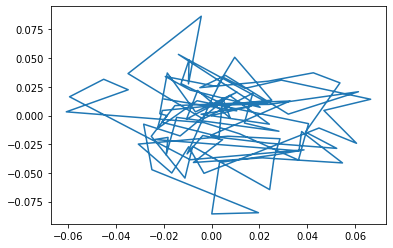

In [6]:
# large lambda, confined track
init_pos = [0., 0.]
t_ = np.linspace(0, 0.2, 101) 
D = 0.175 
well_pos = [0, 0] 
lambda_ = 255 
baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
plt.plot(baseHPW[0], baseHPW[1]);

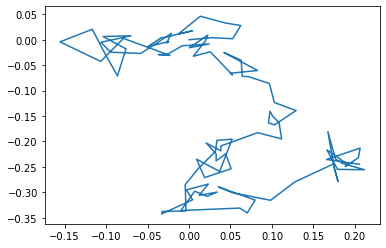

In [8]:
# small lambda, diffusive track
init_pos = [0., 0.]
t_ = np.linspace(0, 0.2, 101) 
D = 0.175 
well_pos = [0, 0] 
lambda_ = 0.025 
baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
plt.plot(baseHPW[0], baseHPW[1]);

### Map Estimator

In the paper: Fast Bayesian inference of optical trap stiffness and particle diffusion, the analytical form of the map estimator is dervied and used here.

In [9]:
def MAP_hpw(sx, dt):
    
    lam = np.log(np.sum(sx[1:] ** 2) / np.sum(sx[1:] * sx[:-1])) / dt

    I = 1 - np.exp(-2 * lam  *dt)
    D = lam * (np.sum((sx[1:] - sx[:-1] * np.exp(-lam*dt)) ** 2) / I / len(sx))

    return D, lam

In [26]:
# large lambda, confined track
np.random.seed(seed)
init_pos = [0., 0.]
t_ = np.linspace(0, 0.2, 202) 
D = 0.175 
well_pos = [0, 0] 
lambda_ = 255 
baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
D_, lam = MAP_hpw(baseHPW[1], np.diff(t_)[0])
print('The map estimate of D is: %f, lambda is: %f' %(D_, lam))

The map estimate of D is: 0.181934, lambda is: 242.768597


In [27]:
# small lambda, diffusive track
np.random.seed(seed)
init_pos = [0., 0.]
t_ = np.linspace(0, 0.2, 202) 
D = 0.175 
well_pos = [0, 0] 
lambda_ = 0.025 
baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
D_, lam = MAP_hpw(baseHPW[1], np.diff(t_)[0])
print('The map estimate of D is: %f, lambda is: %f' %(D_, lam))

The map estimate of D is: 0.187188, lambda is: 5.045568


we see that for very weak well strength lambda, the map estimator cannot recover the true value.

### MCMC - Guassian Likelihood

In [31]:
# large lambda, confined track
np.random.seed(seed)
init_pos = [0., 0.]
framerate = 0.002
pixelToUm = 0.106
t_ = np.linspace(0, 0.2, 101) 
D = 0.175 
well_pos = [0, 0] 
lambda_ = 255
baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 

In [32]:
D_scaled = D * framerate / pixelToUm**2
lambda_scaled = lambda_ * framerate

sx, sy = baseHPW[0]/pixelToUm, baseHPW[1]/pixelToUm
sdx, sdy = np.diff(baseHPW[0]/pixelToUm), np.diff(baseHPW[1]/pixelToUm)
sdt = np.ones((len(sdx), ))

In [34]:
D_scaled

0.0311498754004984

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
C:\Users\jiayu\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


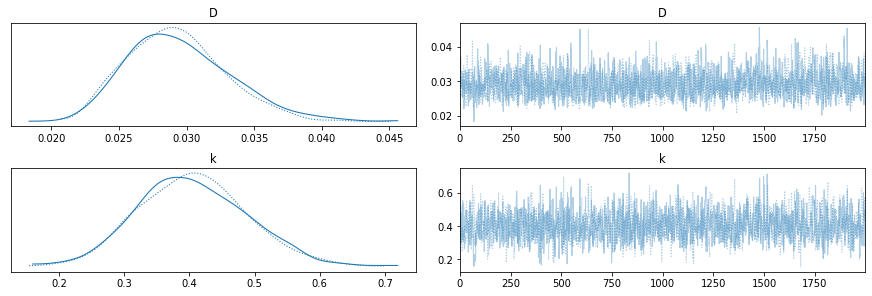

In [35]:
model = pm.Model()

with model: 
    
    D = pm.Lognormal('D', -3, 2)
    k = pm.Lognormal('k', -1, 1)
    
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-k*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-k*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*k*sdt))/k)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)
    
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=2)
    
pm.traceplot(trace);

### MCMC - MvNormal

The idea is to turn the above guassion likelihood into MvNormal with mean vector containing cx and cy, and cov contains D and $\lambda$. Doing so we can easliy incorporate the measurement noise term by adding it to the diag terms of the cov.

In [38]:
def HPW_logp(data): # n_times is number of dts
    
    sigma0 = 10
    n_times = len(sx) - 1
    
    # main diag
    a = np.zeros(n_times+1)
    b = np.ones(n_times+1)
    b2 = np.zeros(n_times+1)
    a[0], b[0] = 1, 0
    b[-1], b2[-1] = 0, 1
    
    # off diag
    c = -np.ones(n_times)
    k = lam/D * (1/(1-tt.exp(-2*lam))) * tt.exp(-lam)
    
    Sigma_T = k * ((1/sigma0**2/k + 1) * np.diag(a, k=0) + \
                  np.diag(c, k=-1) + np.diag(c, k=1) + (1+tt.exp(-lam)) / \
                  (tt.exp(-lam)) * np.diag(b, k=0) + np.diag(b2, k=0) / (tt.exp(-lam)) )  
    
    Sigma = tt.nlinalg.matrix_inverse(Sigma_T) 
    
    logp = -tt.log(pm.math.det(Sigma)) - 0.5*pm.math.dot(pm.math.dot((sx), Sigma_T), (sx)) - \
           0.5*pm.math.dot(pm.math.dot((sy), Sigma_T), (sy)) 

    return logp

In [39]:
model2 = pm.Model()

with model2: 
    
    D = pm.Lognormal('D', -3, 2)
    lam = pm.Lognormal('lam', -1, 1)
    
    like = pm.DensityDist('like', HPW_logp, observed=1)

In [40]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


C:\Users\jiayu\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


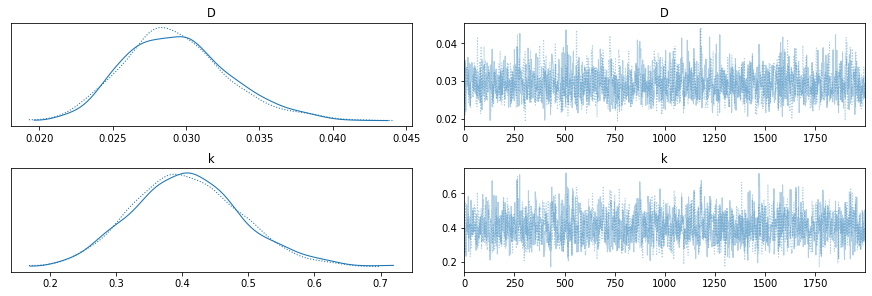

In [41]:
pm.traceplot(trace);

we see that the mvnormal model is the same as the gaussian likelihood case, but turning model into this format allows us to add measurement noises on top in a very straight forward fashion.